<a href="https://colab.research.google.com/github/JosephGesnouin/Data-Science--Cheat-Sheet/blob/master/TP_Mines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Apprentissage profond pour la réduction de dimension (avec beaucoup de franglais)

##Joseph Gesnouin - joseph.gesnouin@mines-paristech.fr

Assurez vous que le notebook utilise le GPU disponible dans google collab: "Execution -> modifier le type d'execution ->  GPU"

## Introduction
Apprendre des jeux de données mutidimentionels n’est pas une tâche aisée. Tandis
que les jeux de données de faibles dimension sont très facilement manipulables car il est aisé de représenter la structure inhérente de leurs données, il est à l’inverse plus compliqué de réaliser des traitements pour des jeux de données de grande dimension. 

La réduction de dimension permet d’apprendre une nouvelle représentation
des données à partir des données originales. Malheureusement, les méthodes classiques de réduction de dimension ne parviennent pas à apprendre avec précision une nouvelle représentation de données lorsque celles-ci sont volumineuses. Ces méthodes souffrent de la malédiction de la dimensionnalité: des données fortement corrélées, clairsemées, bruitées et hétérogènes.

L’objectif de ce TP est de proposer une méthode combinant la réduction de dimension et l'apprentissage profond pour apprendre une représentation précise des données.

Dans un premier temps, nous nous interesserons aux méthodes dites classiques de réduction de dimension, puis vous implémenterez certaines approches d'apprentissage profond réduction de dimension avec comme objectif final un clustering des instances du groupe de données transformé. (AE, CNN AE, VAE).
Dans un second temps, nous regarderons en quoi la réduction de dimension peut-être intéréssante pour le débruitage de données et finalement vous proposerez une approche combinant apprentissage profond et réduction de dimension classique.


## <u> Raisons de la réduction de la dimensionnalité</u>

- La plupart des points d'un hypercube de grande dimension sont très proches de la frontière et risquent d'être très éparses, ce qui rend les prévisions beaucoup moins fiables que si elles étaient réalisées pour des dimensions inférieures.
- Un très grand nombre de caractéristiques pour un entraînement peut rendre l'entraînement extrêmement lent.
- Il est difficile de visualiser un ensemble de données contenant un grand nombre de caractéristiques.

## <u>Avantages</u>

- Moins de temps pour entrainer un modèle.
- Visualisation facile de l'ensemble de données contenant 2 ou 3 composantes principales. Ou via des approches de visualisation (T-SNE, UMAP)
- Peut (ou non) amener à des performances supérieures.

## <u>Inconvenients</u>

- Perte d'informations.

La réduction de la dimensionnalité peut être obtenue des manières suivantes :

- <b> Élimination des caractéristiques </b> : On réduit l'espace des caractéristiques en en éliminant certaines. Cette méthode présente toutefois un inconvénient: nous ne tirons aucune information des caractéristiques supprimées.

- <b> Sélection d'éléments </b> : Nous appliquons des tests statistiques afin de les classer en fonction de leur importance, puis nous sélectionnons un sous-ensemble de caractéristiques. Cette sélection souffre à nouveau de la perte d'informations et est moins stable car les différents tests donnent des notes d'importance différentes aux caractéristiques.

- <b> **Extraction des caractéristiques** </b> : Nous créons de nouvelles caractéristiques indépendantes, où chaque nouvelle caractéristique est une combinaison de chacune des anciennes caractéristiques indépendantes. Ces techniques peuvent se subdiviser en deux familles de méthodes:

<ul>
    <li> Celles dont l’approche est linéaire: les axes utilisés sont des combinaisons linéaires des variables initiales. Ces algorithmes essaient de choisir la projection linéaire ”optimale/intéressante” de la data sur un espace vectoriel reduit. Elles peuvent s’avérer puissantes, mais ne prennent pas en compte l’importance de certaines structures non-linéaires dans la data. </li>
    <li>Les approches non-linéaires: La plupart de ces méthodes s’inspirent des méthodes linéaires telle que la PCA. Ces approches s’avèrent plus sensibles à certaines structures de données [1]. Contrairement aux méthodes linéaires facilement généralisables à divers problèmes de réduction de dimension, il peut être compliqué de réussir à généraliser ce type d’algorithme afin qu’il soit performant dans tous les types de structure non linéaire qu’un "data scientist" soit amené à rencontrer.</li>
</ul>

[1] *Laurens van der Maaten, Eric Postma, Jaap van den Herik Dimensionality
Reduction: A Comparative Review*


## Non linéarité?

L'idée principale des de la réduction de dimension est d'apprendre une représentation de bas niveau d'une donnée multi-dimensionnelle de haut niveau. Essayons de comprendre le processus d'encodage à l'aide d'un exemple. Considérons un espace de représentation de données (N dimentional space qui est utilisé pour repersenter les données) et considérons les points de données repersentés par deux variables : x1 et x2.  Le "Maninfold" est l'espace à l'intérieur de l'espace de représentation des données dans lequel se trouve la véritable information.

In [ ]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import numpy as np
import plotly.io as pio
pio.renderers.default = 'colab'


## generate random data
N = 50
random_x = np.linspace(2, 10, N)
random_y1 = np.linspace(2, 10, N)
random_y2 = np.linspace(2, 10, N)

trace1 = go.Scatter(x = random_x, y = random_y1, mode="markers", name="Actual Data")
trace2 = go.Scatter(x = random_x, y = random_y2, mode="lines", name="Model")
layout = go.Layout(title="2D Data Representation Space", xaxis=dict(title="x2", range=(0,12)), 
                   yaxis=dict(title="x1", range=(0,12)), height=400, 
                   annotations=[dict(x=5, y=5, xref='x', yref='y', text='This 1D line is the Data Manifold (where data resides)',
                   showarrow=True, align='center', arrowhead=2, arrowsize=1, arrowwidth=2, arrowcolor='#636363',
                   ax=-120, ay=-30, bordercolor='#c7c7c7', borderwidth=2, borderpad=4, bgcolor='orange', opacity=0.8)])
figure = go.Figure(data = [trace1], layout = layout)
iplot(figure)

Pour représenter ces données, nous utilisons actuellement 2 dimensions x1 et x2. Il est cependant possible de réduire les dimensions de cet espace pour des dimensions inférieures, c'est-à-dire en une dimension. Par exemple en définissant les dimensions suivantes:

    Point de référence sur la ligne : A
    Angle L avec un axe horizontal

Dans ce cas, n'importe quel point B, sur la ligne A peut être repersenté en termes de distance "d" de A et d'angle L.

In [ ]:
random_y3 = [2 for i in range(100)]
random_y4 = random_y2 + 1
trace4 = go.Scatter(x = random_x[4:24], y = random_y4[4:300], mode="lines")
trace3 = go.Scatter(x = random_x, y = random_y3, mode="lines")
trace1 = go.Scatter(x = random_x, y = random_y1, mode="markers")
trace2 = go.Scatter(x = random_x, y = random_y2, mode="lines")
layout = go.Layout(xaxis=dict(title="x1", range=(0,12)), yaxis=dict(title="x2", range=(0,12)), height=400,
                   annotations=[dict(x=2, y=2, xref='x', yref='y', text='A', showarrow=True, align='center', arrowhead=2, arrowsize=1, arrowwidth=2, 
                                     arrowcolor='#636363', ax=20, ay=-30, bordercolor='#c7c7c7', borderwidth=2, borderpad=4, bgcolor='orange', opacity=0.8), 
                                dict(x=6, y=6, xref='x', yref='y', text='B', showarrow=True, align='center', arrowhead=2, arrowsize=1, arrowwidth=2, arrowcolor='#636363',
                                     ax=20, ay=-30, bordercolor='#c7c7c7', borderwidth=2, borderpad=4, bgcolor='yellow', opacity=0.8), dict(
                                     x=4, y=5, xref='x', yref='y',text='d', ay=-40), 
                                dict(x=2, y=2, xref='x', yref='y', text='angle L', ax=80, ay=-10)], title="2D Data Repersentation Space", showlegend=False)
data = [trace1, trace2, trace3, trace4]
figure = go.Figure(data = data, layout = layout)
iplot(figure)



#################

random_y3 = [2 for i in range(100)]
random_y4 = random_y2 + 1
trace4 = go.Scatter(x = random_x[4:24], y = random_y4[4:300], mode="lines")
trace3 = go.Scatter(x = random_x, y = random_y3, mode="lines")
trace1 = go.Scatter(x = random_x, y = random_y1, mode="markers")
trace2 = go.Scatter(x = random_x, y = random_y2, mode="lines")
layout = go.Layout(xaxis=dict(title="u1", range=(1.5,12)), yaxis=dict(title="u2", range=(1.5,12)), height=400,
                   annotations=[dict(x=2, y=2, xref='x', yref='y', text='A', showarrow=True, align='center', arrowhead=2, arrowsize=1, arrowwidth=2, 
                                     arrowcolor='#636363', ax=20, ay=-30, bordercolor='#c7c7c7', borderwidth=2, borderpad=4, bgcolor='orange', opacity=0.8), 
                                dict(x=6, y=6, xref='x', yref='y', text='B', showarrow=True, align='center', arrowhead=2, arrowsize=1, arrowwidth=2, arrowcolor='#636363',
                                     ax=20, ay=-30, bordercolor='#c7c7c7', borderwidth=2, borderpad=4, bgcolor='yellow', opacity=0.8), dict(
                                     x=4, y=5, xref='x', yref='y',text='d', ay=-40), 
                                dict(x=2, y=2, xref='x', yref='y', text='angle L', ax=80, ay=-10)], title="Latent Distance View Space", showlegend=False)
data = [trace1, trace2, trace3, trace4]
figure = go.Figure(data = data, layout = layout)
iplot(figure)

La question clé ici est de savoir avec quelle logique ou règle, le point B peut être représenté en termes de A et d'angle L. En d'autres termes, quelle est l'équation entre B, A et L?

 Il n'y a pas d'équation fixe mais une équation possible est obtenue par le processus d'apprentissage non supervisé. En termes simples, le processus d'apprentissage peut être défini comme une règle/équation qui convertit B sous la forme de A et L: c'est la réduction de dimension.


Typiquement, les entrées x1 et x2 peuvent être représentées dans l'espace latent de dimension réduite d: 

Si les coordonnées des points A et B dans l'espace de représentation des données sont : 

- Point A : (x1A, x2A)  
- Point B : (x1B, x2B)   

alors leurs coordonnées dans l'espace latent (l'espace de dimension réduite) seront :   

(x1A, x2A) ---> (0, 0)  
(x1B, x2B) ---> (u1B, u2B)  

- Point A : (0, 0)  
- Point B : (u1B, u2B)   

Où u1B et u2B peuvent être représentés sous la forme d'une distance entre le point B et le point de référence A:  

u1B = x1B - x1A  
u2B = x2B - x2A
    

Maintenant, u1B et u2B peuvent être représentés comme une combinaison de la distance d et de l'angle L. Et si nous réalisons une rotation de l'angle L, vers l'axe horizontal, L deviendra 0. c'est-à-dire  

**=> (d, L)**     
**=> (d, 0)** (après rotation)  

La forme réduite des données (x1, x2) est donc (d, 0) dans l'espace latent: c'est le résultat du processus d'encodage permettant de représenter nos données dans des espaces de dimensions moindre: 1D. Vous avez fait de la reduction de dimension manuelle pour des données linéaires. Bravo!
 

Cependant, les mêmes règles ne peuvent être appliquées à tous les types de données. Par exemple, dans l'exemple précédent, nous avons projeté des données linéaires dans une dimension et éliminé l'angle L. Mais que faire si les données ne peuvent pas être projetées correctement? Considérons par exemple les données suivantes:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning:

In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.



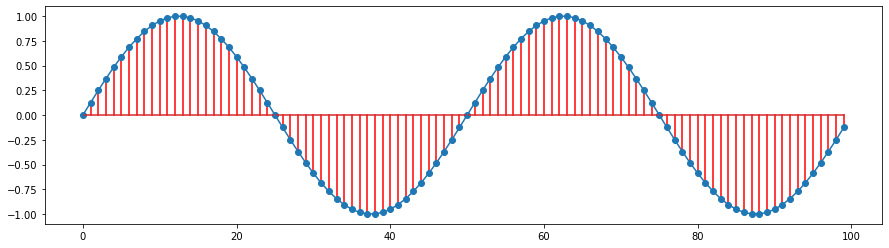

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np
fs = 100 # sample rate 
f = 2 # the frequency of the signal
x = np.arange(fs) # the points on the x axis for plotting
y = [ np.sin(2*np.pi*f * (i/fs)) for i in x]

% matplotlib inline
plt.figure(figsize=(15,4))
plt.stem(x,y, 'r', );
plt.plot(x,y);

Dans ce type de format de données, le problème essentiel sera d'obtenir une projection des données en une seule dimension sans perdre d'informations. Lorsque ce type de données est projeté dans l'espace latent, beaucoup d'informations sont perdues et il est presque impossible de les déformer et de les projeter à nouveau pour obtenir la forme originale des données. Quel que soit le nombre de décalages et de rotations appliqués, les données originales ne pouront pas être récupérées.

On parle alors d'algorithmes non-linéaires pour traiter efficacement ces données. L'intuition est la suivante : pour un maninfold, les approches non-linéaires ont la propriété de courber l'espace afin d'obtenir une vue linéaire des données.  Par exemple, les auto-encoders appliquent cette propriété dans leurs couches cachées, ce qui leur permet d'apprendre des représentations de dimension réduite dans l'espace latent. 

L'image suivante décrit cette propriété : 

![](https://i.imgur.com/gKCOdiL.png)


##Passons un peu à l'implémentation: effet de la reduction de dimension pour le clustering

In [ ]:
## load the libraries 
## load the libraries 
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
tf.random.set_seed(42)

import keras

from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D, BatchNormalization, Flatten, Conv2DTranspose, Reshape,concatenate
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
from keras.models import Model
from imgaug import augmenters
from random import randint
import pandas as pd
import numpy as np



from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D, Dropout, LeakyReLU, add
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
from keras.models import Model
from imgaug import augmenters
from random import randint

import os 
os.environ['PYTHONHASHSEED'] = '0'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import numpy as np
np.random.seed(37)
import random as rn
rn.seed(1254)
import tensorflow as tf
tf.random.set_seed(0)

from tensorflow.compat.v1.keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

Found GPU at: /device:GPU:0


In [ ]:
### read dataset 
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data(path="mnist.npz")
#fashion_mnist = keras.datasets.fashion_mnist
#(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_imgs = train_images.copy()

train_x = train_images.reshape(-1, 28, 28, 1)
test_x = test_images.reshape(-1, 28, 28, 1)
train_y = train_labels
test_y = test_labels

###on travaille sur le test set directement car plus petit: histoire que le notebook tourne en entier pendant la durée du TP
train_x = test_x
train_y = test_y
#val_x = test_x
#val_y = test_y

## normalize and reshape the predictors  
train_x = train_x / 255

## create train and validation datasets
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.1)


## reshape the inputs
train_x = train_x.reshape(-1, 784)
val_x = val_x.reshape(-1, 784)

11493376/11490434 [==============================] - 0s 0us/step


On travaille ici sur le jeu de données Mnist: un jeu de données de qui contient 70 000 images en niveaux de gris réparties sur 10 catégories. Les images montrent des chiffres, en basse résolution (28 x 28 pixels).

Pour que le TP soit réalisable en temps et en heure on va travailler sur un subset de MNIST: 9000 instances de train pour la réduction de dimension et 1000 instances de validation que l'on va projeter via les algorithmes de réduction de dimension puis clusteriser pour essayer de trouver des sous-groupes.

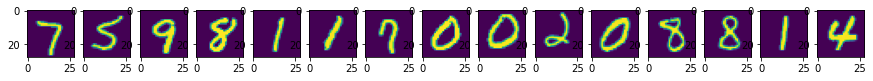

In [ ]:
from PIL import Image 
f, ax = plt.subplots(1,15)
f.set_size_inches(15, 40)
for i in range(15):
    ax[i].imshow(train_x[i].reshape(28, 28))
plt.show()

##Essayons dans un premier temps de réaliser un clustering sur les données brutes pour voir si on est capables (sans label) de trouver des groupes d'instances qui correspondent à la réalité via K-means:

In [ ]:
from sklearn.cluster import MiniBatchKMeans
import time
start = time.time()
n_digits = len(np.unique(test_y))

# Initialize and fit KMeans algorithm 30 times
res_kmeans = []
for i in (range(30)):
  kmeans = MiniBatchKMeans(n_clusters = n_digits, init = "k-means++")
  kmeans.fit(val_x)

  #  record centroid values
  centroids = kmeans.cluster_centers_

  # determine cluster labels
  X_clusters = kmeans.predict(val_x)
  predicted_labels = X_clusters
  res_kmeans.append(sum(predicted_labels != val_y)/len(val_y)*100)

end = time.time()
print(end - start)

3.8057808876037598


Evaluons maintenant la performance du clustering avec l'accuracy: moyenne des 30 runs et standard deviation

In [ ]:
print(np.mean(res_kmeans))
print(np.std(res_kmeans))

90.09000000000002
5.498687722235794


**Disclaimer**: l'algorithme K-means est non déterministe, cela implique de devoir le lancer plusieurs fois pour avoir une estimation *correcte* de sa performance de clustering sur un jeu de données, dans notre cas 30 fois (pour pouvoir faire des tests paramétriques), il existe des variantes déterministes de k-means ou améliorées que vous pourriez utiliser pour améliorer le TP (voir des mélanges de modèles gaussiens bien plus robustes pour le clustering).

**Disclaimer**: En clustering on ne dispose pas des labels, ni du nombre de classes réel, sinon on ferait de la classification... Dans notre cas MNIST est utilisé pour la visualisation et disposant des labels, on utilise l'accuracy comme métrique mais en règle générale on utilise des métriques types de clustering pour évaluer sans label: NMI/ ARI bien plus appropriés. Par soucis de simplicité on va rester sur de l'accuracy, cela ne change pas réellement les résultats pour évaluer les méthodes mais faire du clustering avec accuracy finale vous est impossible dans la réalité. Gardez le en tête.


Il nous est aussi possible de visualiser les prédictions des clusters pour quelques images:

In [ ]:
def infer_cluster_labels(kmeans, actual_labels):
  inferred_labels = {}

  for i in range(kmeans.n_clusters):

      # find index of points in cluster
      labels = []
      index = np.where(kmeans.labels_ == i)

      # append actual labels for each point in cluster
      labels.append(actual_labels[index])

      # determine most common label
      if len(labels[0]) == 1:
          counts = np.bincount(labels[0])
      else:
          counts = np.bincount(np.squeeze(labels))

      # assign the cluster to a value in the inferred_labels dictionary
      if np.argmax(counts) in inferred_labels:
          # append the new number to the existing array at this slot
          inferred_labels[np.argmax(counts)].append(i)
      else:
          # create a new array in this slot
          inferred_labels[np.argmax(counts)] = [i]

      #print(labels)
      #print('Cluster: {}, label: {}'.format(i, np.argmax(counts)))
      
  return inferred_labels

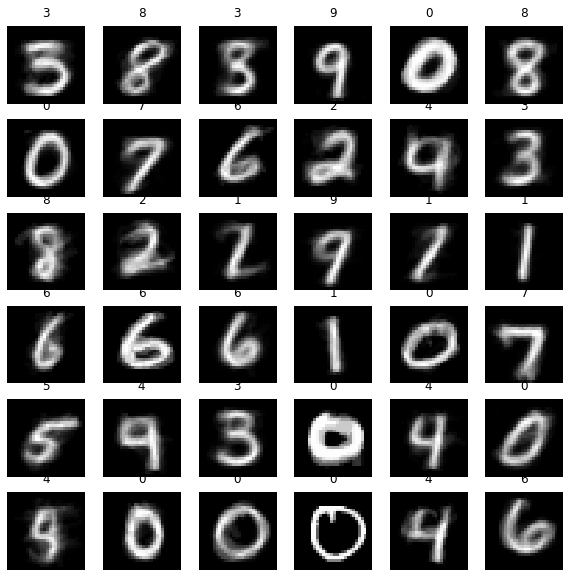

In [ ]:
lab = ["t-shirt","trouser","pullover","dress","coat","sandal","shirt","sneaker","bag","ankle boot"]
# Initialize and fit KMeans algorithm
kmeans = MiniBatchKMeans(n_clusters = 36)
kmeans.fit(val_x)

# record centroid values
centroids = kmeans.cluster_centers_

# reshape centroids into images
images = centroids.reshape(36, 28, 28)
images *= 255
images = images.astype(np.uint8)

# determine cluster labels
cluster_labels = infer_cluster_labels(kmeans, val_y)

# create figure with subplots using matplotlib.pyplot
fig, axs = plt.subplots(6, 6, figsize = (10, 10))
plt.gray()

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):
    
    # determine inferred label using cluster_labels dictionary
    for key, value in cluster_labels.items():
        if i in value:
            ax.set_title('{}'.format(key))
    
    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')
    
# display the figure
fig.show()

##Maintenant essayons de réduire la dimension des images de FashionMNIST avec une approche linéaire (la PCA) et évaluons le résultat du clustering sur les données projetées dans un espace latent

L'ACP consiste à transformer des variables corrélées en axes décorrélés les uns des autres. Ces axes sont composés uniquement de combinaisons linéaires des variables précédentes. Cette méthode est une des première méthode d'analyse factorielle et moteur central de toutes les autres. La question de l'ACP se ramène à un problème de diagonalisation de la matrice de variance covariance.

Elle est majoritairement utilisée pour débruiter rapidement des données en considérent que les vecteurs propres que l'on décide d'oublier sont des axes bruités, mais sert également à décorreler les axes les uns aux autres.


In [ ]:
from sklearn.decomposition import PCA
# Make an instance of the Model
n_components = 10 # We keep 10 components
pca = PCA(n_components = n_components)

pca.fit(train_x) #fit the data according to our PCA instance
print("Number of components before PCA  = " + str(train_x.shape[1]))
print("Number of components after PCA = " + str(pca.n_components_)) 


Number of components before PCA  = 784
Number of components after PCA = 10


**Disclaimer:** Pour tout le TP on va travailler avec des données transposées avec 10 components, ce n'est presque rien, les méthodes proposées ici peuvent être bien meilleur pour le clustering si l'on augmente un peu le nombre de components conservés.

Nous transformons maintenant les données en fonction de la PCA:

In [ ]:
Clus_dataSet = pca.transform(train_x)
print("Dimension of our data after PCA = " + str(Clus_dataSet.shape))

Dimension of our data after PCA = (9000, 10)


Essayons de reconstruire une image en fonction de nos données projetées dans un espace de dimension réduit via PCA:

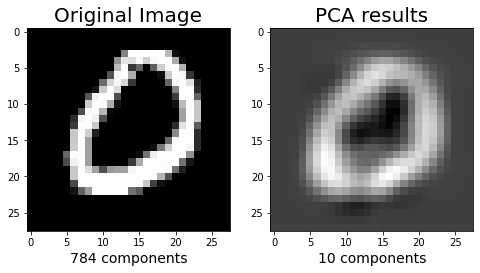

In [ ]:
approximation = pca.inverse_transform(Clus_dataSet)
#image reconstruction using the less dimensioned data
plt.figure(figsize=(8,4));
n = 8 #index value, change to view different data
# Original Image
plt.subplot(1, 2, 1);
plt.imshow(train_x[n].reshape(28, 28),
 cmap = plt.cm.gray,);
plt.xlabel(str(train_x.shape[1])+" components", fontsize = 14)
plt.title("Original Image", fontsize = 20);
# 196 principal components
plt.subplot(1, 2, 2);
plt.imshow(approximation[n].reshape(28, 28),
 cmap = plt.cm.gray,);
plt.xlabel(str(Clus_dataSet.shape[1]) +" components", fontsize = 14)
plt.title("PCA results", fontsize = 20);

Visualisons à présent l'espace latent de dimension 10 dans un espace de dimension 2 obtenu par T-SNE: pour visualiser un peu à quoi ressemble un espace latent.

In [ ]:
from sklearn.manifold import TSNE


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(Clus_dataSet)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 9000 samples in 0.012s...
[t-SNE] Computed neighbors for 9000 samples in 0.773s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9000
[t-SNE] Computed conditional probabilities for sample 2000 / 9000
[t-SNE] Computed conditional probabilities for sample 3000 / 9000
[t-SNE] Computed conditional probabilities for sample 4000 / 9000
[t-SNE] Computed conditional probabilities for sample 5000 / 9000
[t-SNE] Computed conditional probabilities for sample 6000 / 9000
[t-SNE] Computed conditional probabilities for sample 7000 / 9000
[t-SNE] Computed conditional probabilities for sample 8000 / 9000
[t-SNE] Computed conditional probabilities for sample 9000 / 9000
[t-SNE] Mean sigma: 0.750603
[t-SNE] KL divergence after 250 iterations with early exaggeration: 93.277550
[t-SNE] KL divergence after 300 iterations: 3.624696
t-SNE done! Time elapsed: 18.490222692489624 seconds


In [ ]:
# Utility function

def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=32)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(<Figure size 576x576 with 1 Axes>,
 [Text(-3.1754699, -8.857248, '0'),
  Text(-3.5027056, 9.76425, '1'),
  Text(-1.210729, 6.097839, '2'),
  Text(-4.573075, 1.3276174, '3'),
  Text(5.343017, -3.4865363, '4'),
  Text(0.65217316, -4.269246, '5'),
  Text(-9.069281, -2.8264952, '6'),
  Text(9.244217, 4.2846537, '7'),
  Text(0.40754333, 1.0802963, '8'),
  Text(7.2660556, -2.3428633, '9')])

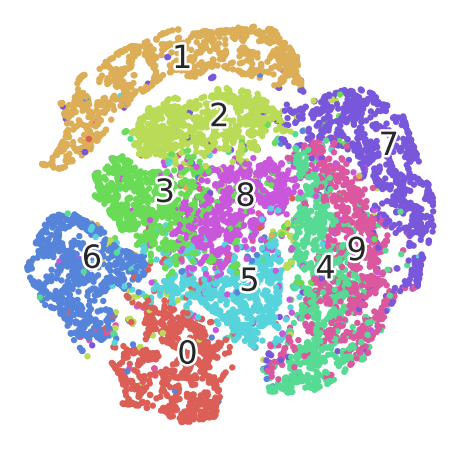

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123

tsne_results =  np.array(tsne_results, dtype=np.float32)
y_train = np.array(train_y, dtype=np.float32)
fashion_scatter(tsne_results, train_y)

Evidement, travailler avec un espace de dimension 2 n'a que peu de sens, mais cela vous montre que même avec 2 dimensions au lieu de 780 initiales, on peut récupérer certains patterns permettant de séparer les classes de manière non supervisée, et c'est bien plus facile à visualiser à l'oeil.

Finalement, effectuons un clustering sur les données projetées dans un espace de dimension 10 obtenu par PCA:

In [ ]:
Clus_dataSet = pca.transform(val_x)
print("Dimension of our data after PCA = " + str(Clus_dataSet.shape))

# Initialize and fit KMeans algorithm 30 times
res_kmeans_PCA = []
start = time.time()
for i in (range(30)):
  kmeans = MiniBatchKMeans(n_clusters = n_digits,init = "k-means++")
  kmeans.fit(Clus_dataSet)

  #  record centroid values
  centroids = kmeans.cluster_centers_

  # determine cluster labels
  X_clusters = kmeans.predict(Clus_dataSet)
  predicted_labels = X_clusters
  res_kmeans_PCA.append(sum(predicted_labels != val_y)/len(val_y)*100)

end = time.time()
print(end - start)

Dimension of our data after PCA = (1000, 10)
1.4197568893432617


In [ ]:
print(np.mean(res_kmeans_PCA))
print(np.std(res_kmeans_PCA))

89.59666666666668
5.370691037680554


Qu'en concluez vous comparé à un K-means sur les données brutes? en accuracy en temps d'éxécution et en stockage? 

Rappel: le clustering sur les données brutes se fait sur 784 variables, celui avec PCA se fait avec seulement 10 variables.

Ttest_indResult(statistic=0.34563652067529027, pvalue=0.7308664205468494)

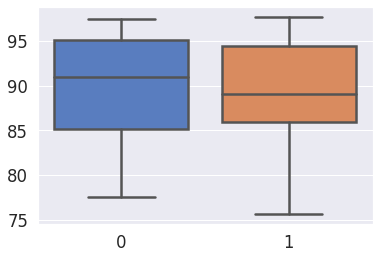

In [ ]:
from scipy import stats
ax = sns.boxplot(data=[res_kmeans, res_kmeans_PCA])
stats.ttest_ind(res_kmeans, res_kmeans_PCA, equal_var = True)

Petit rappel, d'après la [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html): la p-value obtenue ici vient d'un two-tailed student test, on peut diviser la p value par deux pour avoir un one-tailed test.

##Essayons maintenant avec des approches de réduction de dimensions non-linéaires classiques: LLE et Isomap.



##Implémentation de Locally Linear Embedding (LLE) sur Mnist avant un clustering

Locally Linear Embedding peut se définir comme une multitude de méthodes factorielles linéaires comparées et concaténées une-à-une dans des zones locales. On pourrait le comparer à une succession d'ACP lancées dans des zones locales du jeu de données puis comparées globalement afin de garder la meilleur qualité de répartition de données non-linéaires.
Celui-ci se base sur la construction d'un graphe de similarité des points du jeu de données et se base sur une conjecture géometrique: on suppose que tous les points du jeux de données ainsi que ces voisins sont séparables ou disposés d'une manière linéaire dans une zone locale. Ainsi, de la même manière, chaque point et ses voisins dans l'espace de de données de dimension réduite seront également répartis de manière linéaire: Chaque point est reconstruit en fonction de ses voisins.

**Pour comprendre rapidement**: imaginez les platistes, ils imaginent que la terre est plate parce que la zone locale sur laquelle ils se trouvent sur la terre est presque "plate": linéaire, par contre si on prend la terre dans sa globalité, on a plein de zones locales linéaires, mais la structure générale ne l'est pas, c'est le même principe.

Une variante Hessienne de LLE existe (Hessian Eigenmapping): LLE est sensible aux problèmes de régularisation. Quand le nombre de voisins est superieur au nombre de dimensions, la matrice gardant en mémoire chacun de champs locaux linéaires n'a pas suffisament de rangs. Pour éviter ce problème, on peut utiliser une forme hessienne pour chaque groupe local afin de bien définir la structure linéaire.



[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 9000 samples in 0.013s...
[t-SNE] Computed neighbors for 9000 samples in 0.252s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9000
[t-SNE] Computed conditional probabilities for sample 2000 / 9000
[t-SNE] Computed conditional probabilities for sample 3000 / 9000
[t-SNE] Computed conditional probabilities for sample 4000 / 9000
[t-SNE] Computed conditional probabilities for sample 5000 / 9000
[t-SNE] Computed conditional probabilities for sample 6000 / 9000
[t-SNE] Computed conditional probabilities for sample 7000 / 9000
[t-SNE] Computed conditional probabilities for sample 8000 / 9000
[t-SNE] Computed conditional probabilities for sample 9000 / 9000
[t-SNE] Mean sigma: 0.000182
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.297195
[t-SNE] KL divergence after 300 iterations: 2.996047
t-SNE done! Time elapsed: 16.008262395858765 seconds


(<Figure size 576x576 with 1 Axes>,
 [Text(-6.4267716, 9.776301, '0'),
  Text(3.8178287, -7.810652, '1'),
  Text(-10.5378475, 0.16715148, '2'),
  Text(-0.5295414, -11.186785, '3'),
  Text(4.832746, -1.631982, '4'),
  Text(0.99794364, -1.3290454, '5'),
  Text(3.4435134, 0.71922094, '6'),
  Text(9.713837, 2.5412593, '7'),
  Text(-2.6736484, -0.29069832, '8'),
  Text(6.7662487, 7.7140017, '9')])

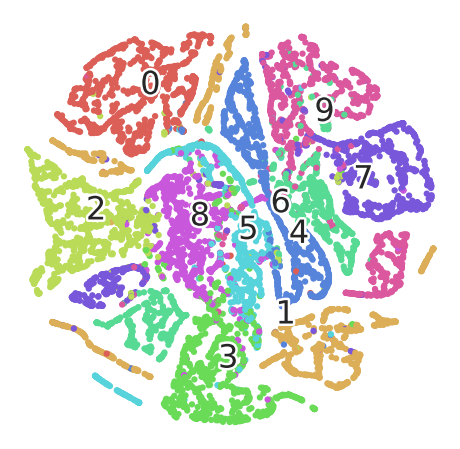

In [ ]:
from sklearn.manifold import *

embedding = LocallyLinearEmbedding(n_components=10)
Clus_dataSet = embedding.fit_transform(train_x)
Clus_dataSet.shape

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(Clus_dataSet)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123

tsne_results =  np.array(tsne_results, dtype=np.float32)
y_train = np.array(train_y, dtype=np.float32)
fashion_scatter(tsne_results, train_y)

In [ ]:
Clus_dataSet = embedding.fit_transform(val_x)
print("Dimension of our data after LLE = " + str(Clus_dataSet.shape))

start = time.time()
# Initialize and fit KMeans algorithm 30 times
res_kmeans_LLE = []
for i in (range(30)):
  kmeans = MiniBatchKMeans(n_clusters = n_digits,init = "k-means++")
  kmeans.fit(Clus_dataSet)

  #  record centroid values
  centroids = kmeans.cluster_centers_

  # determine cluster labels
  X_clusters = kmeans.predict(Clus_dataSet)
  predicted_labels = X_clusters
  res_kmeans_LLE.append(sum(predicted_labels != val_y)/len(val_y)*100)

end = time.time()
print(end - start)

Dimension of our data after LLE = (1000, 10)
0.9867780208587646


In [ ]:
print(np.mean(res_kmeans_LLE))
print(np.std(res_kmeans_LLE))

92.73333333333332
5.425085764811054


Ttest_indResult(statistic=-1.8428219880814134, pvalue=0.07046744054913143)

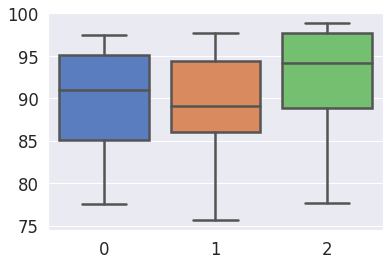

In [ ]:
from scipy import stats
ax = sns.boxplot(data=[res_kmeans, res_kmeans_PCA, res_kmeans_LLE])
stats.ttest_ind(res_kmeans, res_kmeans_LLE)

##Implémentation d'ISOMAP sur FashionMnist avant un clustering

**Isomap** cherche un espace de dimension réduite qui conserve les distances géodésiques entre tous les points au lieu de la distance euclidienne. Cette méthode se base sur les plus proches voisins de chacune des instances afin de conserver cette distance. Dans un premier temps, Isomap génère un graphe de voisinage entre toutes les instances du jeu de données. Un fois le graphe de voisinage généré, une table de dissimilarité est créé grâce à l'algorithme de distance de Djikstra. De cette manière, Isomap dispose de toute l'information nécéssaire afin de voir quels sont les points les plus proches des autres. Pour finir, on utilise l'algorithme MDS (Multi-Dimensional Scaling) sur cette table de dissimilarité.

**Multi-Dimensional Scaling** cherche une représentation des données dans un espace vectoriel réduit, pour lequel la projection des individus respecte bien les distances et sont équivalentes à celles de l'espace vectoriel d'origine de dimension bien superieure. C'est une technique pour analyser la similarité ou dissimilarité entre les données.

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 9000 samples in 0.013s...
[t-SNE] Computed neighbors for 9000 samples in 0.431s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9000
[t-SNE] Computed conditional probabilities for sample 2000 / 9000
[t-SNE] Computed conditional probabilities for sample 3000 / 9000
[t-SNE] Computed conditional probabilities for sample 4000 / 9000
[t-SNE] Computed conditional probabilities for sample 5000 / 9000
[t-SNE] Computed conditional probabilities for sample 6000 / 9000
[t-SNE] Computed conditional probabilities for sample 7000 / 9000
[t-SNE] Computed conditional probabilities for sample 8000 / 9000
[t-SNE] Computed conditional probabilities for sample 9000 / 9000
[t-SNE] Mean sigma: 3.130534
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.422409
[t-SNE] KL divergence after 300 iterations: 3.282752
t-SNE done! Time elapsed: 15.644046545028687 seconds


(<Figure size 576x576 with 1 Axes>,
 [Text(6.478178, -7.7930975, '0'),
  Text(-0.5491389, 3.72959, '1'),
  Text(-0.41849813, -5.62974, '2'),
  Text(-10.576311, -0.8037452, '3'),
  Text(3.4012327, 8.301369, '4'),
  Text(-6.660987, 7.5204244, '5'),
  Text(-4.2585735, -9.598981, '6'),
  Text(8.455623, -0.594376, '7'),
  Text(-4.367987, 0.23958932, '8'),
  Text(7.3874316, 4.5796556, '9')])

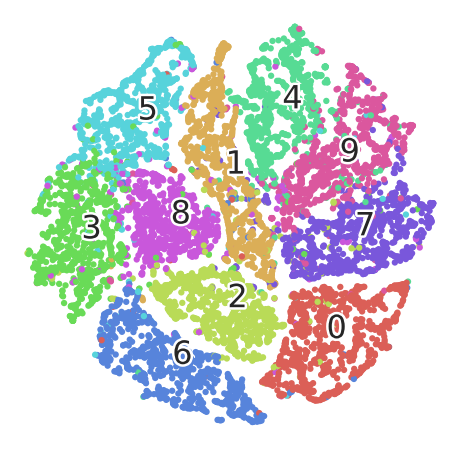

In [ ]:
from sklearn.manifold import *

embedding = Isomap(n_components=10)
Clus_dataSet = embedding.fit_transform(train_x)
Clus_dataSet.shape

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(Clus_dataSet)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123

tsne_results =  np.array(tsne_results, dtype=np.float32)
y_train = np.array(train_y, dtype=np.float32)
fashion_scatter(tsne_results, train_y)

In [ ]:

Clus_dataSet = embedding.fit_transform(val_x)
print("Dimension of our data after LLE = " + str(Clus_dataSet.shape))

start = time.time()
# Initialize and fit KMeans algorithm 30 times
res_kmeans_Isomap = []
for i in (range(30)):
  kmeans = MiniBatchKMeans(n_clusters = n_digits,init = "k-means++")
  kmeans.fit(Clus_dataSet)

  #  record centroid values
  centroids = kmeans.cluster_centers_

  # determine cluster labels
  X_clusters = kmeans.predict(Clus_dataSet)
  predicted_labels = X_clusters
  res_kmeans_Isomap.append(sum(predicted_labels != val_y)/len(val_y)*100)

end = time.time()
print(end - start)

Dimension of our data after LLE = (1000, 10)
1.2024986743927002


In [ ]:
print(np.mean(res_kmeans_Isomap))
print(np.std(res_kmeans_Isomap))

91.11333333333336
7.610682550789311


Ttest_indResult(statistic=-0.5869283917925248, pvalue=0.5595295835106148)

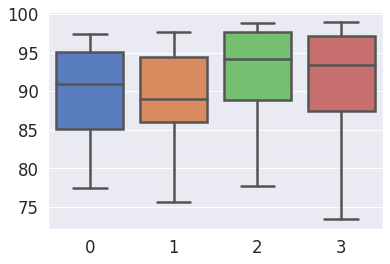

In [ ]:
ax = sns.boxplot(data=[res_kmeans, res_kmeans_PCA, res_kmeans_LLE, res_kmeans_Isomap])
stats.ttest_ind(res_kmeans, res_kmeans_Isomap)

# Pour la suite du TP:
Vous trouverez une liste des approches classique de ML pour la réduction de dimension que vous pouvez implémenter pour les évaluer sur Fashionmnist en suivant le même format: 

* transformation de train_x avec 10 components
* visualisation 2D du jeu de données transformé via T-SNE
* application de 30 k-means++ sur le jeu de données val_x transformé avec 10 components et extraction de l'accuracy moyenne.
* finalement, vous récupérerez chacune des listes d'accuracy par methodes et effectuerez une visualisation boxplot et des tests de student d'adéquation des moyennes pour évaluer quelle est la "meilleure méthode" sur FashionMNIST.


**Kernel-ACP / Multi-Dimensional Scaling / Local Tagent Space Alignement (LTSA)
/ Non negative matrix factorization (NMF) / Kernel PCA / Hessian LLE**

Implémentez au moins deux des quatres méthodes proposées avant de passer à la partie deep learning:



*  https://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold
*  https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
* https://scikit-learn.org/stable/modules/manifold.html


Prenez un peu de temps pour comprendre très brièvement comment chaque méthode marche, en particulier la NMF qui est élégante.
 Vous pouvez aussi regarder brièvement UMAP et T-SNE qui ne sont pas à proprement parlé des méthodes de réduction de dimension mais des méthodes de visualisation.


In [ ]:
### Votre implémentation méthode 1 + TSNE 

In [ ]:
### Votre implémentation méthode 1 + kmeans

In [ ]:
### Résultats de votre méthode 1

In [ ]:
### Votre implémentation méthode 2 + TSNE 

In [ ]:
### Votre implémentation méthode 2 + kmeans

In [ ]:
### Résultats de votre méthode 2

In [ ]:
#formule pour le boxplot
#ax = sns.boxplot(data=[res_kmeans, res_kmeans_PCA, res_kmeans_LLE, res_kmeans_Isomap, METHODE1, METHODE2])

In [ ]:
#test de student d'adéquation des moyennes 

#Partie 2: apprentissage profond pour la réduction de dimension: Auto-encoder

Un **AutoEncodeur** prend des données d'entrée avec une très haute dimensionnalité et va fonctionner à travers un réseau neuronal. Celui-ci va essayer de compresser les données pour les obtenir dans une représentation plus petite.


![](https://i.imgur.com/9PrT1KA.png)

Il se déroule en deux étapes


*  La première est ce que l'on peut considérer comme l'étape d'encodage: L'encodeur correspond à un amas de couche (fully connected, convolutives, récurrentes...) qui vont prendre l'entrée et la comprimer jusqu'à obtenir une représentation de dimension plus réduite que l'entrée: c'est le 'goulot d'étranglement' ou bottleneck.
*   A partir du bottleneck, la seconde partie correspond à une tentative de reconstruction de la donnée initiale.

Plus le nombre de dimensions dans l'espace latent est élevé, plus les reconstructions seront claires et robustes.

La fonction de cout d'un AE, consiste simplement à reconstruire le jeu de données initial et calculer la perte de reconstruction par rapport à l'entrée. Dans sa forme la plus basique, la solution optimale d'un AE est fortement lié à la PCA:

Afin de calculer les valeurs des couches cachées, on multiplie simplement les poids entre l'entrée et la couche, on a donc la formule suivante:

z = f(Wx)

Pour obtenir la sortie, on multiplie les poids entre les couches cachées et la sortie par la valeur des couches cachées, on obtient donc:

y = g(Vz)

les fonctions f et g sont libres, tant qu'elles sont non lineaires et qu'on peut les dériver pour la backpropagation. On obtient donc la fonction suivante:

y = g(V(f(Wx)) = VWx

nous permettant d'obtenir la fonction objectif:

![](https://i.imgur.com/HLH7ZhO.png)

Ce qui correspond à la fonction objectif de la PCA. Cependant, l'autoencodeur est bien plus flexible que la PCA: chaque couche dispose d'une fonction d'activation (Relu, tanh, sigmoide...) permettant d'introduire la notion de non linéarité, contrairement à la PCA qui ne peut représenter que des transformations linéaires. Avec des contraintes de dimensionalité et de parcimonie appropriées, les AE peuvent donc apprendre des projections de données plus intéréssantes que l'ACP, de plus ils peuvent être empilés...

##denoising AE
Différentes techniques existent pour empêcher un AE d'apprendre la fonction identité afin d'améliorer sa capacité à apprendre des représentations plus riches: en obligeant le latent space à avoir un petit nombre de neurones, on force le réseau à apprendre une représentation intelligente des données. Il existe d'autres façon de forcer le réseau à apprendre une bonne représentation: en ajoutant du bruit aléatoire à nos données d'entrées pour récupérer l'image originale sans ce bruit.

De cette façon, l'AE ne peut pas simplement copier l'entrée et sa sortie car l'entrée est bruitée, on lui demande alors de soustraire le bruit et de comprendre les données sous jacentes: c'est le denoising AE.



Passons maintenant aux méthodes d'apprentissage profond pour la réduction de dimension: les auto-encodeurs (Dense et CNN).

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Un deep autoencoder dense multicouches:

In [ ]:
## input layer
input_layer = Input(shape=(784,))

## encoding architecture
encode_layer1 = Dense(512, activation='relu')(input_layer)
encode_layer1 = BatchNormalization()(encode_layer1)
encode_layer2 = Dense(256, activation='relu')(encode_layer1)
encode_layer2 = BatchNormalization()(encode_layer2)
encode_layer2 = Dense(128, activation='relu')(encode_layer2)
encode_layer2 = BatchNormalization()(encode_layer2)
encode_layer3 = Dense(32, activation='relu')(encode_layer2)
encode_layer3 = BatchNormalization()(encode_layer3)

## latent view
latent_view   = Dense(10, activation='sigmoid',name="latent")(encode_layer3)

## decoding architecture
decode_layer1 = Dense(32, activation='relu')(latent_view)
decode_layer1 = BatchNormalization()(decode_layer1)
decode_layer2 = Dense(128, activation='relu')(decode_layer1)
decode_layer2 = BatchNormalization()(decode_layer2)
decode_layer2 = Dense(256, activation='relu')(decode_layer2)
decode_layer2 = BatchNormalization()(decode_layer2)
decode_layer3 = Dense(512, activation='relu')(decode_layer2)
decode_layer3 = BatchNormalization()(decode_layer3)

## output layer
output_layer  = Dense(784)(decode_layer3)

encoder = Model(input_layer, latent_view)
model = Model(input_layer, output_layer)

In [ ]:
model.compile(optimizer='adam', loss='mse')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=15, min_lr=1e-10)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto')
model.fit(train_x, train_x, epochs=1000, batch_size=32, validation_data=(val_x, val_x), callbacks=[early_stopping,reduce_lr], shuffle=False)

Epoch 1/1000
282/282 [==============================] - 6s 8ms/step - loss: 0.1848 - val_loss: 0.0542
Epoch 2/1000
282/282 [==============================] - 2s 6ms/step - loss: 0.0506 - val_loss: 0.0435
Epoch 3/1000
282/282 [==============================] - 2s 6ms/step - loss: 0.0456 - val_loss: 0.0412
Epoch 4/1000
282/282 [==============================] - 2s 6ms/step - loss: 0.0426 - val_loss: 0.0392
Epoch 5/1000
282/282 [==============================] - 2s 6ms/step - loss: 0.0404 - val_loss: 0.0373
Epoch 6/1000
282/282 [==============================] - 2s 6ms/step - loss: 0.0387 - val_loss: 0.0362
Epoch 7/1000
282/282 [==============================] - 2s 6ms/step - loss: 0.0371 - val_loss: 0.0351
Epoch 8/1000
282/282 [==============================] - 2s 6ms/step - loss: 0.0357 - val_loss: 0.0341
Epoch 9/1000
282/282 [==============================] - 2s 6ms/step - loss: 0.0344 - val_loss: 0.0329
Epoch 10/1000
282/282 [==============================] - 2s 6ms/step - loss: 0.033

In [ ]:
preds = model.predict(val_x)

In [ ]:
from PIL import Image 
f, ax = plt.subplots(1,10)
f.set_size_inches(20, 20)
for i in range(10):
    ax[i].imshow(val_x[i].reshape(28, 28))
plt.show()

Visualisons la reconstruction de notre autoencoder dense:

In [ ]:
f, ax = plt.subplots(1,10)
f.set_size_inches(20, 20)
for i in range(10):
    ax[i].imshow(preds[i].reshape(28, 28))
plt.show()

Réalisons un clustering des données projetées dans l'espace latent de l'auto-encoder (10 dimensions)

In [ ]:
encoder.summary()


In [ ]:
Clus_dataSet = encoder.predict(val_x)

start = time.time()
# Initialize and fit KMeans algorithm 30 times
res_kmeans_AE_dense = []
for i in (range(30)):
  kmeans = MiniBatchKMeans(n_clusters = n_digits,init = "k-means++")
  kmeans.fit(Clus_dataSet)

  #  record centroid values
  centroids = kmeans.cluster_centers_

  # determine cluster labels
  X_clusters = kmeans.predict(Clus_dataSet)
  predicted_labels = X_clusters
  res_kmeans_AE_dense.append(sum(predicted_labels != val_y)/len(val_y)*100)

end = time.time()
print(end - start)

In [ ]:
print(np.mean(res_kmeans_AE_dense))
print(np.std(res_kmeans_AE_dense))

In [ ]:
ax = sns.boxplot(data=[res_kmeans, res_kmeans_PCA, res_kmeans_LLE, res_kmeans_Isomap, res_kmeans_AE_dense])
stats.ttest_ind(res_kmeans, res_kmeans_AE_dense)

En fonction du code Keras précédent et du backbone fourni, créer un auto encoder avec des Convolutions 2D, du Maxpool2D, de la batchnormalization et une fonction d'activation rélu, faites bien attention à ce que votre decoder soit de la même forme que votre encoder.

In [ ]:
# input layer
input_layer = Input(shape=(28, 28, 1))

#NB dimension
latent_dim = 10

x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(input_layer)
x = BatchNormalization()(x)
x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = Flatten()(x)
latent = Dense(latent_dim, name="latent")(x)

decoded = Dense(7 * 7* 32, activation="relu")(latent)
x = Reshape((7, 7, 32))(decoded)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = BatchNormalization()(x)
decoder_outputs = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

AE = keras.Model(input_layer, decoder_outputs, name="AE")
AE.summary()

encoder = keras.Model(input_layer, latent, name="encoder")
encoder.summary()


In [ ]:
AE.compile(optimizer='adam', loss='mse')
train_x2 = train_x.reshape(-1, 28, 28, 1)
val_x2 = val_x.reshape(-1, 28, 28, 1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=15, min_lr=1e-10)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

history = AE.fit(train_x2, train_x2,validation_data=(val_x2, val_x2), epochs=400, batch_size=32, callbacks=[early_stopping,reduce_lr])

On va visualiser la reconstruction de l'AE CNN:

In [ ]:
from PIL import Image 
f, ax = plt.subplots(1,10)
f.set_size_inches(20, 20)
for i in range(10):
    ax[i].imshow(val_x[i].reshape(28, 28))
plt.show()

preds = AE.predict(val_x2)
f, ax = plt.subplots(1,10)
f.set_size_inches(20, 20)
for i in range(10):
    ax[i].imshow(preds[i].reshape(28, 28))
plt.show()

et faire un clustering sur l'embedding:

In [ ]:
Clus_dataSet = encoder.predict(val_x2)

start = time.time()
# Initialize and fit KMeans algorithm 30 times
res_kmeans_AE_CNN = []
for i in (range(30)):
  kmeans = MiniBatchKMeans(n_clusters = n_digits,init = "k-means++")
  kmeans.fit(Clus_dataSet)

  #  record centroid values
  centroids = kmeans.cluster_centers_

  # determine cluster labels
  X_clusters = kmeans.predict(Clus_dataSet)
  predicted_labels = X_clusters
  res_kmeans_AE_CNN.append(sum(predicted_labels != val_y)/len(val_y)*100)

end = time.time()
print(end - start)

In [ ]:
print(np.mean(res_kmeans_AE_CNN))
print(np.std(res_kmeans_AE_CNN))

In [ ]:
ax = sns.boxplot(data=[res_kmeans, res_kmeans_PCA, res_kmeans_LLE, res_kmeans_Isomap, res_kmeans_AE_dense,res_kmeans_AE_CNN])
stats.ttest_ind(res_kmeans, res_kmeans_AE_CNN)

Implémentation d'un Variational Auto-encoder:

Selon l'exemple: https://keras.io/examples/generative/vae/
Implementez un VAE en l'entrainant sur train_x2 avec 10 dimensions, récupérer la partie encoder, projeter val_x2 dans l'espace latent et effectuer un clustering comme précédement.

Denoising Auto-encoder


Ici, on a des images propres, que se passe-t-il si on a des données bruitées?


https://imgaug.readthedocs.io/en/latest/source/api_augmenters_arithmetic.htmle



In [ ]:
# Lets add sample noise - Salt and Pepper
noise = augmenters.ImpulseNoise(0.3)
seq_object = augmenters.Sequential([noise])

train_x_n = seq_object.augment_images(train_x2 * 255) / 255
val_x_n = seq_object.augment_images(val_x2 * 255) / 255

In [ ]:
f, ax = plt.subplots(1,5)
f.set_size_inches(20, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x[i].reshape(28, 28))
plt.show()

In [ ]:
f, ax = plt.subplots(1,5)
f.set_size_inches(20, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x_n[i].reshape(28, 28))
plt.show()

In [ ]:
# input layer
input_layer = Input(shape=(28, 28, 1))

#NB dimension
latent_dim = 10

x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(input_layer)
x = BatchNormalization()(x)
x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = Flatten()(x)
latent = Dense(latent_dim, name="latent")(x)

decoded = Dense(7 * 7* 32, activation="relu")(latent)
x = Reshape((7, 7, 32))(decoded)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = BatchNormalization()(x)
decoder_outputs = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

AE = keras.Model(input_layer, decoder_outputs, name="AE")
AE.summary()

encoder = keras.Model(input_layer, latent, name="encoder")
encoder.summary()


In [ ]:
AE.compile(optimizer='adam', loss='mse')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=15, min_lr=1e-10)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

history = AE.fit(train_x_n, train_x_n,validation_data=(val_x_n, val_x_n), epochs=400, batch_size=32, callbacks=[early_stopping,reduce_lr])

In [ ]:
from PIL import Image 
f, ax = plt.subplots(1,10)
f.set_size_inches(20, 20)
for i in range(10):
    ax[i].imshow(val_x_n[i].reshape(28, 28))
plt.show()

preds = AE.predict(val_x_n)
f, ax = plt.subplots(1,10)
f.set_size_inches(20, 20)
for i in range(10):
    ax[i].imshow(preds[i].reshape(28, 28))
plt.show()

In [ ]:
Clus_dataSet = encoder.predict(val_x_n)

start = time.time()
# Initialize and fit KMeans algorithm 30 times
res_kmeans_AE_CNN_D = []
for i in (range(30)):
  kmeans = MiniBatchKMeans(n_clusters = n_digits,init = "k-means++")
  kmeans.fit(Clus_dataSet)

  #  record centroid values
  centroids = kmeans.cluster_centers_

  # determine cluster labels
  X_clusters = kmeans.predict(Clus_dataSet)
  predicted_labels = X_clusters
  res_kmeans_AE_CNN_D.append(sum(predicted_labels != val_y)/len(val_y)*100)

end = time.time()
print(end - start)

In [ ]:
print(np.mean(res_kmeans_AE_CNN_D))
print(np.std(res_kmeans_AE_CNN_D))

In [ ]:
ax = sns.boxplot(data=[res_kmeans, res_kmeans_PCA, res_kmeans_LLE, res_kmeans_Isomap, res_kmeans_AE_dense,res_kmeans_AE_CNN,res_kmeans_AE_CNN_D])
stats.ttest_ind(res_kmeans, res_kmeans_AE_CNN)

#Partie 5: combiner apprentissage profond et Machine learning classique: combinaison d'un AE avec LLE

Un certain nombre de travaux ont étudié les stratégies de clustering en combinant au préalable des méthodes de réduction de dimension ou d'apprentissage profond. Ces méthodes suivent une méthode séquentielle où une représentation dans un espace de dimension réduit est apprise avant d'obtenir des groupes à l'aide d'un clustering.

Dans cette partie finale du tp, vous proposerez une nouvelle procédure recherchant simultanément une nouvelle représentation des données contenant le maximum d'information (en utilisant un denoising AE), et un graphe de similarité caractérisant au mieux la proximité entre les points (avec la LLE). 
Cela consistera dans l'optimisation du problème suivant:

![](https://i.imgur.com/31GlcQp.png)

Pour vous aider: voici une première version backbone de l'approche: vous pouvez l'améliorer en bruitant les données d'entrée, en utilisant des CNN, en changeant la structure de l'AE... demandez moi!

In [ ]:
itd = 10

input_bottleneck = Input(shape=(itd,), name="inp_bt")
input_img = Input(shape=(784,), name="inp_img")
input_S = Input(shape=(itd,), name="inp_S")

encoded = Dense(256, activation='relu')(input_img)

bottlenek = Dense(itd, activation='relu', name="bottleneck")(encoded)

decoded = Dense(256, activation='relu')(bottlenek)
output = Dense(784, activation='sigmoid', name="logits")(decoded)


final_dense = concatenate(
    [input_bottleneck, 
     output,
     input_S
    ], name="concatenate")

model = Model([input_bottleneck, input_img, input_S], [final_dense, output])

bottleneck_model = Model(inputs=model.get_layer("inp_img").input, outputs=model.get_layer("bottleneck").output)


In [ ]:
l = 2
def custom_loss(y_true, y_pred):
    bottle=y_pred[:,:itd]
    pred = y_pred[:,itd:784+itd]
    Sb = y_pred[:,784+itd:]
    
#     return tf.norm(y_true - pred) + l*tf.norm(bottle - Sb)
#     return tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(y_true, pred))))
#     return K.sqrt(K.sum(K.square(y_true - pred))) 
#     return objectives.binary_crossentropy(y_true, pred) + l*objectives.binary_crossentropy(bottle, Sb)
    return K.sqrt(K.sum(K.square(y_true - pred), axis=-1)) + l*K.sqrt(K.sum(K.square(bottle - Sb), axis=-1))

model.compile(optimizer='adam', loss={"concatenate":custom_loss, "logits": None})

In [ ]:
sub_train = [train_x[x:x+100] for x in range(0, len(train_x), 100)]

In [ ]:
for epoch in range(0,30):
    for x in sub_train:
        bottleneck = bottleneck_model.predict(train_x)
        lle = LLEC(n_components=2, n_neighbors=10)
        S = lle.fit_W(bottleneck)
        sdotB = np.dot(S, bottleneck)
        lss = model.train_on_batch(
            [
                 bottleneck, 
                 x,
                 sdotB
            ], 
                x
        )
    print("epoch : ", epoch, " : ",lss)